## Загрузим нужные библиотеки

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

%matplotlib inline


from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# plot_learning_curve(clf, '--', X.values, y['label'].values, cv=3, n_jobs=-1, scoring='recall_macro')



##  подгрузка данных

In [125]:
# df = pd.read_csv("./train_dataset_train.csv", nrows = 100000)
df = pd.read_csv("./train_dataset_train.csv")

In [126]:
def modifydata(df, val = None):
#     id not a feature. Test and train имеют разные Идшники, поэтому там ерунду будет прогнозить
    id_col = df['id'].copy()
    df = df.drop("id", axis=1)

    
#     Сделаем категорию **"ticket_type_nm"** ранговой 
    df["ticket_type_nm"] = pd.Categorical(df["ticket_type_nm"])
    df["ticket_type_nm"].astype('category').cat.codes
    df["ticket_type_nm"] = df["ticket_type_nm"].cat.codes
    
#     Видоизменим категорию "pass_dttm"
    df["day"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
    df["hours"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

#     Меняем типы, чтобы уменьшить объём занимаемой памяти:
    df['hours'] = df['hours'].astype('int8')
    df['day'] = df['day'].astype('int8')
    df['line_id'] = df['line_id'].astype('int8')
    df['ticket_type_nm'] = df['ticket_type_nm'].astype('int8')
    df['entrance_id'] = df['entrance_id'].astype('int16')
    df['entrance_id'] = df['entrance_id'].astype('int16')

    df['time'] = pd.to_datetime(df['pass_dttm'])
    df['time_isweekend'] = (df['time'].dt.dayofweek // 5 == 1).astype('int8')
    df['time_dayofweek'] = df['time'].dt.dayofweek.astype('int8')

#     df = df[df["time_to_under"] < 900]   # для классификации надо чтобы были все данные. Для регрессии не важно

    if 'label' in df.columns:
# классы, которые полохо класифицируются
#     bad_classes = [1002, 1004, 1006, 1007, 1012, 1013, 1017, 1020, 1021, 1023, 1025, 2002, 2009, 2012, 2015, 2016, 2017, 2022, 2024, 3004, 3005, 3006, 3007, 3008, 3009, 3013, 3014, 3016, 3019, 4001, 4002, 4006, 4008, 4009, 4011, 4012, 5002, 5006, 5012, 6005, 6012, 6013, 6014, 6015, 6017, 6019, 6022, 6024, 7007, 7010, 7013, 7014, 7016, 7018, 7019, 8002, 8004, 8006, 8008, 9001, 9002, 9003, 9004, 9011, 9017, 9019, 9021, 9023, 9025, 10001, 10004, 10005, 10006, 10008, 10010, 10013, 10014, 10015, 10019, 10021, 10023, 11006, 11011, 11012, 11013, 11016, 12001, 12003, 12005, 13002, 13003, 13004, 13005, 13006, 14001, 14002, 14004, 14006, 14008, 14013, 14017, 14023, 14026, 14031, 15001, 15004, 15007, 81003, 81004, 81012]
        temp = df["label"].value_counts() < val # 1000
        bad_classes = temp.index[temp.values]

        is_bad_classes = df['label'].isin(bad_classes)
        df_bad_classes = df.drop( df[ ~is_bad_classes].index)
        df_good_classes = df.drop( df[is_bad_classes].index)


        df_bad_classes = df.drop( df[ ~ is_bad_classes].index)

        return df, df_bad_classes, df_good_classes, id_col
    
    else:
        return df, id_col
    
    

In [127]:
df, df_bad_classes, df_good_classes, id_col = modifydata(df, None)

print(df_bad_classes.shape, df_good_classes.shape, df.shape)

(0, 16) (1091021, 16) (1091021, 16)


## Рассмотрим датасет по ближе

In [89]:
df.head(3)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,time,time_isweekend,time_dayofweek
0,40BD89EC85646EFB69E283F39C298E60,40,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12 05:00:13,0,0
1,126727A96489CC976A8C08E5CEB00542,53,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,12,5,2022-09-12 05:00:54,0,0
2,D28CE6A9E0E5B6D213470A97CFF32485,26,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,12,5,2022-09-12 05:00:55,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1074830 entries, 0 to 1091020
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   id              1074830 non-null  int64         
 1   ticket_id       1074830 non-null  object        
 2   ticket_type_nm  1074830 non-null  int8          
 3   entrance_id     1074830 non-null  int16         
 4   entrance_nm     1074830 non-null  object        
 5   station_id      1074830 non-null  int64         
 6   station_nm      1074830 non-null  object        
 7   line_id         1074830 non-null  int8          
 8   line_nm         1074830 non-null  object        
 9   pass_dttm       1074830 non-null  object        
 10  time_to_under   1074830 non-null  float64       
 11  label           1074830 non-null  int64         
 12  day             1074830 non-null  int8          
 13  hours           1074830 non-null  int8          
 14  time            10

In [7]:
df.describe()

,id,ticket_type_nm,entrance_id,station_id,line_id,time_to_under,label,day,hours,time_isweekend,time_dayofweek
count,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06,1.074830e+06
mean,5.459673e+05,2.580051e+01,8.596997e+02,8.602768e+03,8.591321e+00,5.033546e+02,7.722615e+03,1.479729e+01,9.361641e+00,2.350604e-01,2.795979e+00
std,3.150992e+05,1.951754e+01,9.009391e+02,1.247817e+04,1.247842e+01,2.268707e+02,1.167184e+04,1.942422e+00,3.360137e+00,4.240368e-01,1.941946e+00
min,1.000000e+00,0.000000e+00,2.000000e+01,1.002000e+03,1.000000e+00,3.001667e+01,1.002000e+03,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.727602e+05,5.000000e+00,2.150000e+02,3.017000e+03,3.000000e+00,3.179500e+02,3.006000e+03,1.300000e+01,7.000000e+00,0.000000e+00,1.000000e+00
50%,5.464905e+05,1.900000e+01,3.390000e+02,7.009000e+03,7.000000e+00,5.645500e+02,6.013000e+03,1.500000e+01,8.000000e+00,0.000000e+00,3.000000e+00
75%,8.181888e+05,3.800000e+01,2.087000e+03,9.022000e+03,9.000000e+00,6.771667e+02,9.012000e+03,1.600000e+01,1.100000e+01,0.000000e+00,4.000000e+00
max,1.091021e+06,5.900000e+01,2.466000e+03,8.101600e+04,8.100000e+01,8.999833e+02,8.101600e+04,1.900000e+01,2.300000e+01,1.000000e+00,6.000000e+00


<AxesSubplot:>

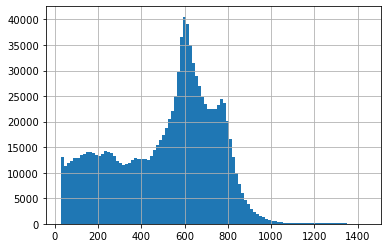

In [69]:
df["time_to_under"].hist(bins = 100)

### **"ticket_type_nm"** 


In [13]:
df["ticket_type_nm"].value_counts()

38    258626
5     173197
57    125905
3     114987
19     57185
10     48340
16     46096
6      44197
51     39033
25     29256
11     24166
14     20548
53     16793
55     15439
17     12663
40      8851
52      6691
54      3148
4       3062
26      2793
48      2572
35      2532
23      2522
58      2261
20      2215
24      1543
9       1249
15      1159
49      1143
7       1033
44       865
12       765
43       533
45       506
2        497
50       353
30       335
56       243
59       229
18       182
37       159
22       141
0        122
29       110
42       108
21        92
31        61
27        60
34        56
8         49
39        44
46        33
13        29
41        24
47        10
1          7
36         6
32         2
33         2
28         2
Name: ticket_type_nm, dtype: int64

<AxesSubplot:xlabel='ticket_type_nm', ylabel='count'>

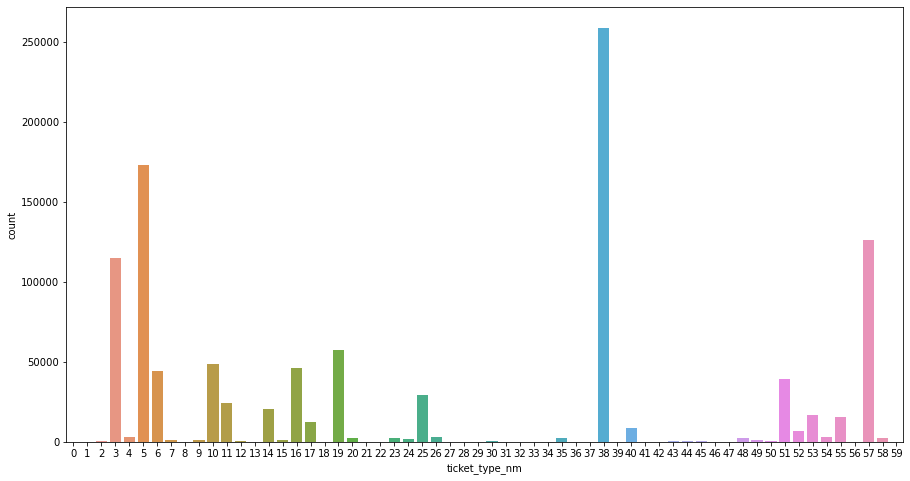

In [14]:
plt.figure(figsize=(15,8))
sns.countplot(x = "ticket_type_nm" , data  = df)  

Кажется нет четкой зависимости между категорией билета и временем между заходи на станцию

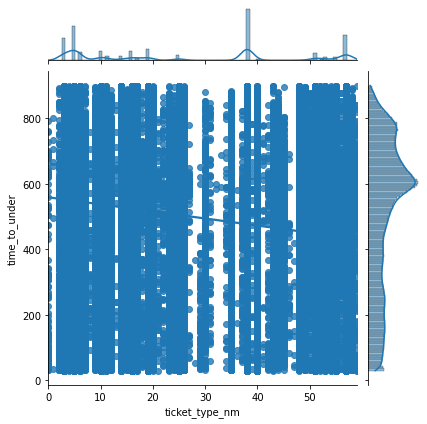

In [15]:
sns.jointplot(x = "ticket_type_nm", y = 'time_to_under', data = df, kind = 'reg')

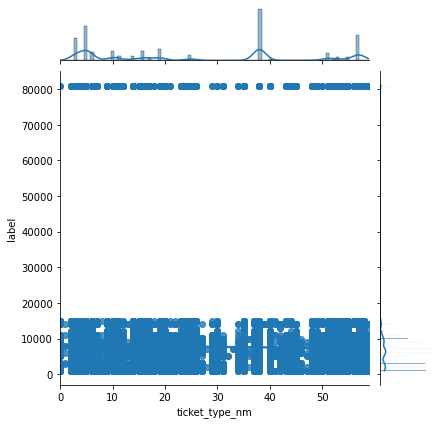

In [16]:
sns.jointplot(x = "ticket_type_nm", y = 'label', data = df, kind = 'reg')

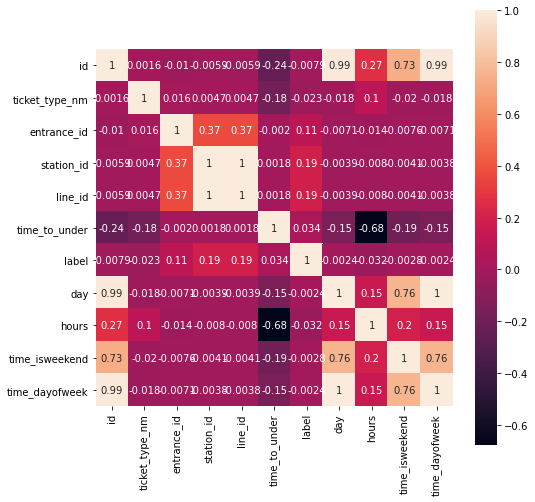

In [235]:
plt.figure(figsize=(8,8))
corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True)

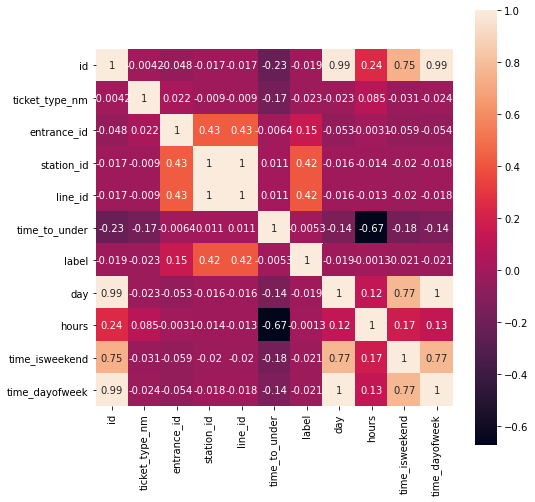

In [236]:
plt.figure(figsize=(8,8))
corr = df_bad_classes.corr()
g = sns.heatmap(corr, square = True, annot=True)

# Classification

Посмотрим на распределение двух основных величин 

<AxesSubplot:>

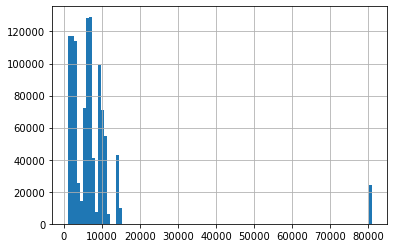

In [8]:
df["label"].hist(bins = 100)

Найдем наиболее популярную станцию и посмотрим инфо по ней:

In [11]:
df["label"].value_counts()

3002     17107
6008     15405
1022     13648
5010     12992
7022     12890
         ...  
13002       24
13003       23
13006       17
13005       14
13004        7
Name: label, Length: 276, dtype: int64

In [12]:
# df["label"].value_counts().index[0]   # номер станции

df[df["label"] == int(df["label"].value_counts().index[ 1 ])].head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,time,time_isweekend,time_dayofweek
64,65,8BE033F1D958FF1E53F97121D51DE779,3,218,Новогиреево (Восточный),8003,Новогиреево,8,Калининская,2022-09-12 05:22:54,834.216667,6008,12,5,2022-09-12 05:22:54,0,0
181,182,B00FE04CA3D4F54DA324610741E5A7A0,57,242,Ботанический сад (Северный),6005,Ботанический сад,6,Калужско-Рижская,2022-09-12 05:26:31,124.616667,6008,12,5,2022-09-12 05:26:31,0,0
626,627,54A042D2EF6DDFE9D444CCD8BB42AC0F,57,2214,Шелепиха (Первый),11005,Шелепиха,11,Большая кольцевая,2022-09-12 05:31:39,561.316667,6008,12,5,2022-09-12 05:31:39,0,0
862,863,14D1E6C4EBE0D40CBA98C82C0D90B961,38,191,Белорусская К (Новый),5001,Белорусская,5,Кольцевая,2022-09-12 05:34:32,828.916667,6008,12,5,2022-09-12 05:34:32,0,0
889,890,0023323A900115BD79BE15E76A676A61,57,303,Кузьминки (Восточный),7009,Кузьминки,7,Таганско-Краснопресненская,2022-09-12 05:34:49,363.883333,6008,12,5,2022-09-12 05:34:49,0,0


Количество классов

266 / 10


Text(0.5, 0, 'Index')

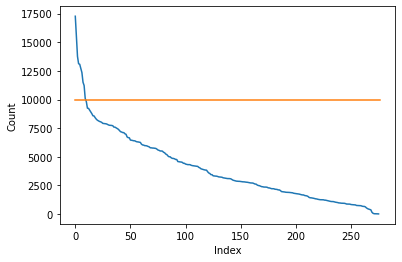

In [53]:
thrval = 10000
print(np.sum(df["label"].value_counts() < thrval), '/', np.sum(df["label"].value_counts() > thrval))


plt.plot(df["label"].value_counts().values)
plt.plot([0, len(df["label"].value_counts())], [thrval, thrval])   # уровень, который отрезаем
plt.ylabel('Count')
plt.xlabel('Index')

In [81]:
df_bad_classes.columns

Index(['id', 'ticket_id', 'ticket_type_nm', 'entrance_id', 'entrance_nm',
       'station_id', 'station_nm', 'line_id', 'line_nm', 'pass_dttm',
       'time_to_under', 'label', 'day', 'hours', 'time', 'time_isweekend',
       'time_dayofweek'],
      dtype='object')

<AxesSubplot:xlabel='station_id', ylabel='Count'>

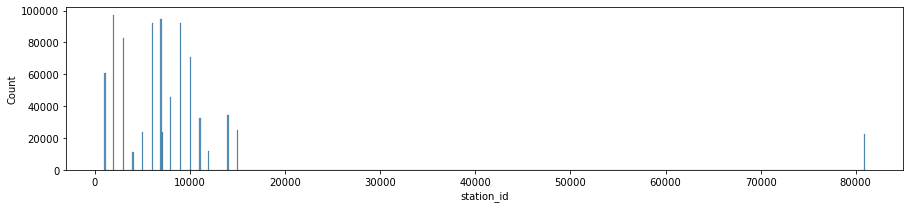

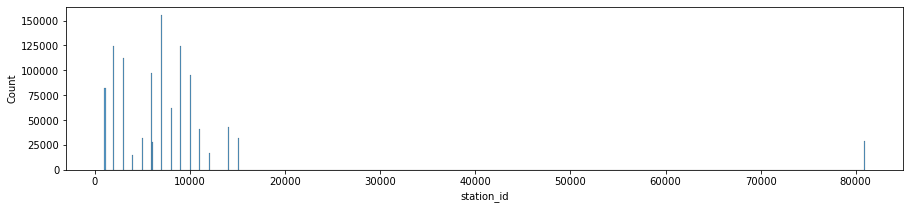

In [105]:
plt.figure(figsize=(15,3))
sns.histplot(df_bad_classes['station_id'])

plt.figure(figsize=(15,3))
sns.histplot(df['station_id'])

In [70]:
valid.columns

Index(['id', 'ticket_id', 'ticket_type_nm', 'entrance_id', 'entrance_nm',
       'station_id', 'station_nm', 'line_id', 'line_nm', 'pass_dttm', 'day',
       'hours', 'time', 'time_isweekend', 'time_dayofweek'],
      dtype='object')

## Сравнение выборок

In [ ]:
df["id"].hist(bins = 100)
valid["id"].hist(bins = 100)

<AxesSubplot:>

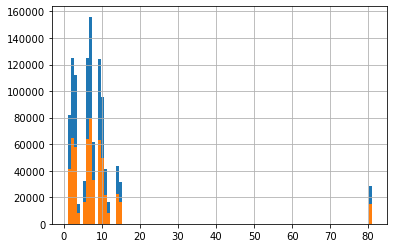

In [72]:
df["line_id"].hist(bins = 100)
valid["line_id"].hist(bins = 100)

<AxesSubplot:>

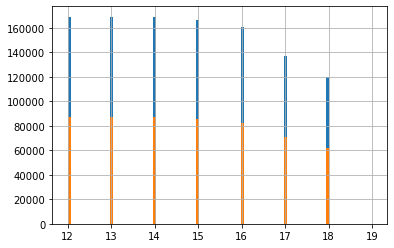

In [73]:
df["day"].hist(bins = 100)
valid["day"].hist(bins = 100)

<AxesSubplot:>

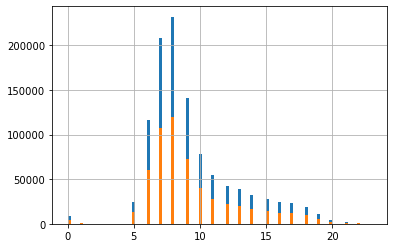

In [74]:
df["hours"].hist(bins = 100)
valid["hours"].hist(bins = 100)

# Обучение и тесты

## Выделим выборки

In [90]:
df = pd.read_csv("./train_dataset_train.csv")
df, df_bad_classes, df_good_classes = modifydata(df, 10000)
print(df_bad_classes.shape, df_good_classes.shape, df.shape)

(960373, 16) (130648, 16) (1091021, 16)


In [91]:
def getFeaturesAndOutput(df):
    if 'time_to_under' in df.columns:
        X = df.drop(["ticket_id", "entrance_nm", "station_nm", "line_nm", "pass_dttm", "label","time_to_under", 'time'], axis = 1)
        y = df[["time_to_under", "label"]]
        return X,y
    else:
        X = valid.drop(["ticket_id", "entrance_nm", "station_nm", "line_nm", "pass_dttm", 'time'], axis = 1)
        return X

In [92]:
Xa, ya = getFeaturesAndOutput(df)
X, y = getFeaturesAndOutput(df_good_classes)

Xb, yb = getFeaturesAndOutput(df_bad_classes)

In [57]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(y['label'])
ylabel = le.transform(y['label'])

# print(le.fit(y['label']),
# le.classes_,
# le.transform(y['label']),
# le.inverse_transform([0, 0, 1, 2]))


In [93]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.columns

Index(['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'day',
       'hours', 'time_isweekend', 'time_dayofweek'],
      dtype='object')

In [95]:
X.head()

,ticket_type_nm,entrance_id,station_id,line_id,day,hours,time_isweekend,time_dayofweek
0,40,2402,11007,11,12,5,0,0
2,26,110,2006,2,12,5,0,0
10,19,110,2006,2,12,5,0,0
28,40,205,5009,5,12,5,0,0
34,11,110,2006,2,12,5,0,0


In [96]:
y_train

,time_to_under,label
486557,292.983333,3002
804044,394.233333,3002
474165,343.300000,5009
707646,759.516667,7015
1065922,472.266667,8001
...,...,...
1070209,373.866667,3002
858762,573.133333,1009
9632,623.066667,7015
135408,367.250000,6008


## Обучение модели

### Для станции 

In [14]:
# %%time

# datalen = y_train.shape[0]
# chunksize = 10000

# clf = RandomForestClassifier(random_state=0, max_depth=15, n_jobs=1, warm_start=True)
# clf.fit(X_train[:chunksize], y_train["label"][:chunksize])

# i = 0
# while i < datalen:
#     clf.fit(X_train[i:i+chunksize], y_train["label"][i:i+chunksize])
#     i = i + chunksize


In [97]:
%%time

clf = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=200, n_jobs=4)
clf.fit(X_train, y_train["label"])

# festo ~4min  n_jobs=2

Wall time: 2.47 s


RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=4, random_state=0)

In [248]:
# классификатор специально для плохих классов
clf_bad = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=200, n_jobs=-1)
clf_bad.fit(Xb, yb["label"])


RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1,
                       random_state=0)

In [20]:
# import pickle

# with open('./clf.data', 'wb') as f:
#     pickle.dump(clf, f)

In [239]:
# %%time
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(random_state=0, solver='lbfgs', n_jobs=-1)
# clf.fit(X_train, y_train["label"])


In [237]:
temp = clf.predict_proba(X)

In [250]:
temp1 = clf_bad.predict_proba(X)

5009
11004
1024


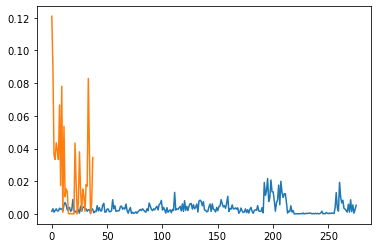

In [313]:
i = 10

print(y[y.index == i]['label'].values[0])
print(clf.classes_[np.argmax(temp[i])])
print(clf_bad.classes_[np.argmax(temp1[i])])

plt.plot(temp[i]);
plt.plot(temp1[i]);


In [282]:
len(y['label'].unique())

238

In [309]:
y.head(10)

,time_to_under,label
0,216.316667,8001
1,648.183333,9011
2,865.333333,7022
3,1048.233333,2022
4,965.600000,2017
5,148.683333,11012
7,229.400000,7014
8,720.616667,5007
9,329.433333,6018
10,945.333333,5009


Wall time: 29 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

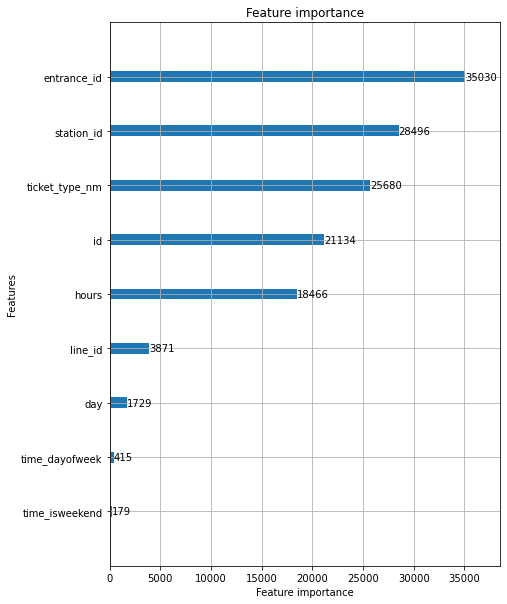

In [58]:
%%time

import lightgbm as lgb

clf = lgb.LGBMClassifier(n_estimators=1500, num_leaves=10, learning_rate=0.05, colsample_bytree=0.75, verbose=100,
                         subsample=0.75, random_state=13, metric='multi_logloss', objective='multiclass', n_jobs=-1)
clf.fit(X, ylabel, eval_metric='multi_logloss')


lgb.plot_importance(clf, figsize=(7,10))

In [59]:
clf.best_score_

defaultdict(dict, {})

In [33]:
# #Converting the dataset in proper LGB format
# d_train = lgb.Dataset(X, label=ylabel)#setting up the parameters

# params = {}
# params['learning_rate'] = 0.05
# params['num_leaves'] = 10
# params['boosting_type']='gbdt' #GradientBoostingDecisionTree
# params['objective']='multiclass' #Multi-class target feature
# params['metric']='multi_logloss' #metric for multi-class
# params['max_depth']=10
# params['num_class']=276 #no.of unique values in the target class not inclusive of the end value#training the model
# params['n_estimators']=1500
# params['verbose'] = 100
# params['n_jobs'] = -1
# params['random_state'] = 13

# clf = lgb.train(params, d_train, 100)


### Для времени

In [98]:
%%time
reg = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=200, n_jobs=-1)

reg.fit(X_train, y_train["time_to_under"])

# фесто 45с n_jobs=-1

Wall time: 2.55 s


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1, random_state=0)

In [21]:
# import pickle

# with open('./reg.data', 'wb') as f:
#     pickle.dump(reg, f)

In [20]:
# %%time 

# from sklearn.linear_model import LinearRegression

# reg = LinearRegression(n_jobs=-1)
# reg.fit(X_train, y_train["time_to_under"])

CPU times: user 353 ms, sys: 23.3 ms, total: 376 ms
Wall time: 94.3 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [60]:
%%time

import lightgbm as lgb

reg = lgb.LGBMRegressor(n_estimators=1500, num_leaves=10, learning_rate=0.05, colsample_bytree=0.75, verbose=100,
                         subsample=0.75, random_state=13, metric='r2', objective='regression', n_jobs=-1)
reg.fit(X, y['time_to_under'], eval_metric='r2')



Wall time: 2.57 s


LGBMRegressor(colsample_bytree=0.75, learning_rate=0.05, metric='r2',
              n_estimators=1500, num_leaves=10, objective='regression',
              random_state=13, subsample=0.75, verbose=100)

In [61]:
reg.best_score_

defaultdict(dict, {})

## Оценка точности

In [99]:
pred_class = clf.predict(X_test)
pred_reg = reg.predict(X_test)

In [63]:
#  for LGBM inverse transform of classes
if type(clf) == lgb.sklearn.LGBMClassifier:
    pred_class = le.inverse_transform(pred_class)

In [100]:
from sklearn.metrics import recall_score, r2_score

rs = recall_score(y_test["label"], pred_class , average='macro')
r2 = r2_score(y_test["time_to_under"], pred_reg)
score = 0.5 * rs +  0.5 * r2

print(rs, r2, score)

0.240904745579802 0.5105320359587164 0.3757183907692592


In [ ]:
# 0.4897555334746157   -- baseline
# 0.2678758686368177   -- baseline, обучение на всех данных.  На паблике 0.092150

# Recall, R2, score
# 2*0.0028946815886393275 0.4765418328846045 0.2397182572366219   -- logit, linreg  public  -0.177917
# 0.051367635290150336 0.5337106363746371 0.2925391358323937 -- RandomForestClassifier, RandomForestRegressor, полный набор
# 0.0038071101519124456 0.5337099924062669 0.2687585512790897 -- RandomForestClassifier, RandomForestRegressor, df["time_to_under"] < 900


# 0.1003784996172645 0.5477282066729828 0.3240533531451237 -- RandomForestClassifier, bad_classes
# 0.7298980069136254 0.5175243103995155 0.6237111586565705   # stationsize < 15000
# 0.12490370842962603 0.5237048533791078 0.3243042809043669  # stationsize < 7000
# 0.240904745579802 0.5105320359587164 0.3757183907692592    # stationsize < 10000


# LGBM, # stationsize < 7000
# 0.1710043969339049 0.5347006858367624 0.3528525413853337
# Public Score = 0.042972

# LGBM, stationsize < 10000
# 0.06935987873302325 0.5263155078550112 0.29783769329401727
# Public Score = 0.001329



In [101]:
%%time

from sklearn.model_selection import cross_validate

scores = cross_validate(clf, X.values, y['label'].values, scoring='recall_macro', cv=5, n_jobs=-1, return_train_score=True)
print('Classification:')
print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
print('Test\t', scores['test_score'].mean(), scores['test_score'].std())


scores1 = cross_validate(reg, X.values, y['time_to_under'].values, scoring='r2', cv=5, n_jobs=-1, return_train_score=True)
print('Regression:')
print('Train\t', scores1['train_score'].mean(), scores1['train_score'].std())
print('Test\t', scores1['test_score'].mean(), scores1['test_score'].std())

print(0.5*scores1['test_score'].mean() + 0.5*scores['test_score'].mean())

Classification:
Train	 0.2787722778628954 0.004338544045341835
Test	 0.15528023132256066 0.041954169158995115
Regression:
Train	 0.6416177727962342 0.014415805234755505
Test	 0.4782292343470019 0.03415935935014842
0.3167547328347813
Wall time: 23.2 s


In [ ]:
## CV metrics
# < 900
# Class           Train 0.13561506174050203 0.003919650939196688,  Test 0.05748999133734326 0.02317111428466088
# Regress         Train 0.6235695720322265 0.01699774672075998,    Test 0.45812485786452795 0.028581941528906817

# stationsize < 1000
# Classification: Train 0.06411120481666817 0.0024074551124603186, Test 0.027039440606936464 0.011243727223666317
# Regression:     Train 0.579278188403807 0.01587261373976514,     Test 0.46565763045506064 0.035428402233769515
# Public Score = 0.141005

# stationsize < 15000
# Classification: Train	 0.7766608130174626 0.0071032513880352225  Test	 0.5059780312150269 0.06739058625640744
# Regression:     Train	 0.7705591530210607 0.008838076905600432   Test	 0.4577849308723593 0.03791206577049757
# 0.4818814810436931  Wall time: 6.27 s
# Public Score = 0.173457

# stationsize < 7000
# Classification: Train	 0.13900015725605608 0.0037958818071982866 Test	 0.05605391160258757 0.0306836823057727
# Regression:     Train	 0.60357617541174 0.015187794866878612     Test	 0.45970415872525844 0.03722895441220533
# 0.257879035163923 Wall time: 2min 14s
# Public Score = 0.133424

# stationsize < 10000,  no ID
# Classification: Train	 0.2787722778628954 0.004338544045341835 Test	 0.15528023132256066 0.041954169158995115
# Regression:     Train	 0.6416177727962342 0.014415805234755505 Test	 0.4782292343470019 0.03415935935014842
# 0.3167547328347813 Wall time: 23.2 s
# Public Score = 0.244189

# LGBM
# stationsize < 10000
# Classification: Train	 0.33192901427429555 0.005872930829746373 Test	 0.11362338163112295 0.05386222823723618
# Regression:     Train	 0.5397642642266066 0.012073370061145386  Test	 0.4547109149300333 0.045197869452318525
# 0.2841671482805781 Wall time: 6min 8s
# Public Score = 0.001329


In [ ]:
#  тупо на всех данных 
%%time

from sklearn.model_selection import cross_validate

scores = cross_validate(clf, Xa.values, ya['label'].values, scoring='recall_macro', cv=5, n_jobs=-1, return_train_score=True)
print('Classification:')
print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
print('Test\t', scores['test_score'].mean(), scores['test_score'].std())


scores = cross_validate(reg, Xa.values, ya['time_to_under'].values, scoring='r2', cv=5, n_jobs=-1, return_train_score=True)
print('Regression:')
print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
print('Test\t', scores['test_score'].mean(), scores['test_score'].std())


### classification_report

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test["label"], pred_class))

              precision    recall  f1-score   support

        1009       0.17      0.14      0.15      3792
        1018       0.27      0.25      0.26      2699
        1019       0.30      0.08      0.12      2232
        1022       0.21      0.33      0.26      4230
        2001       0.14      0.21      0.17      2676
        2003       0.20      0.08      0.12      2520
        2004       0.60      0.33      0.43      2106
        2006       0.17      0.30      0.22      2345
        2007       0.26      0.10      0.14      2253
        2011       0.14      0.21      0.17      2086
        2013       0.21      0.08      0.11      2418
        2014       0.24      0.07      0.11      2219
        2018       0.16      0.11      0.13      2220
        3001       0.28      0.08      0.13      2316
        3002       0.16      0.33      0.21      5133
        3010       0.22      0.27      0.25      2625
        3015       0.15      0.13      0.14      2374
        3018       0.17    

In [102]:
# классы, которые плохо прогнозируются

from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(y_test["label"], pred_class)

bad_classes_classes = sorted(y_test["label"].unique())   #  список классов

bad_classes = []
for i in range(len(mcm)):
    if mcm[i][1,1] <= 1:
        bad_classes.append(bad_classes_classes[i])
#     print(mcm[i][1,1])

print(len(bad_classes),'/',len(bad_classes_classes))

0 / 10


## ищем коилчество посещений ,которое не подходит

In [331]:
%%time

thrs = [15000, 10000, 4000, 3000, 2500, 2000, 1000];

for t in thrs:
    print(t)
    df = pd.read_csv("./train_dataset_train.csv")
    df, df_bad_classes, df_good_classes = modifydata(df, t)
    print(df_bad_classes.shape, df_good_classes.shape, df.shape)

    X, y = getFeaturesAndOutput(df_good_classes)

    scores = cross_validate(RandomForestClassifier(random_state=0, max_depth=2, n_estimators=3, n_jobs=2),
                            X.values, y['label'].values, scoring='recall_macro', cv=5, n_jobs=-1, return_train_score=True)
    print('Classification:')
    print('Train\t', scores['train_score'].mean(), scores['train_score'].std())
    print('Test\t', scores['test_score'].mean(), scores['test_score'].std())


    scores1 = cross_validate(RandomForestRegressor(random_state=0, max_depth=5, n_estimators=3, n_jobs=-1), 
                            X.values, y['time_to_under'].values, scoring='r2', cv=5, n_jobs=-1, return_train_score=True)
    print('Regression:')
    print('Train\t', scores1['train_score'].mean(), scores1['train_score'].std())
    print('Test\t', scores1['test_score'].mean(), scores1['test_score'].std())
    
    print(0.5*scores1['test_score'].mean() + 0.5*scores['test_score'].mean())


15000
(1058208, 17) (32813, 17) (1091021, 17)
Classification:
Train	 0.6630141494841523 0.005015396747037869
Test	 0.6284705632749639 0.06470628077807934
Regression:
Train	 0.5050368702295558 0.010017920606690248
Test	 0.45508652839366565 0.04191400851943784
0.5417785458343147
10000
(960373, 17) (130648, 17) (1091021, 17)
Classification:
Train	 0.16350063117005967 0.00873790225084011
Test	 0.15287697952221507 0.012895761612797646
Regression:
Train	 0.49051613971859326 0.01152793082141878
Test	 0.44214214910984617 0.0339202204417001
0.2975095643160306
4000
(310287, 17) (780734, 17) (1091021, 17)
Classification:
Train	 0.016543048942274534 0.0008070977513912614
Test	 0.0155692845252488 0.0017321273921953304
Regression:
Train	 0.5041447398778537 0.015033215318697743
Test	 0.46208966065398344 0.03749244325951907
0.23882947258961612
3000
(211983, 17) (879038, 17) (1091021, 17)
Classification:
Train	 0.013003748601015594 0.00041964568072929657
Test	 0.012212832403053436 0.001284301657597231


In [ ]:
# RandomForestClassifier(random_state=0, max_depth=2, n_estimators=3, n_jobs=2)
# RandomForestRegressor(random_state=0, max_depth=5, n_estimators=3, n_jobs=-1)

# 15000
# (1058208, 17) (32813, 17) (1091021, 17)
# Classification:
# Train	 0.6630141494841523 0.005015396747037869
# Test	 0.6284705632749639 0.06470628077807934
# Regression:
# Train	 0.5050368702295558 0.010017920606690248
# Test	 0.45508652839366565 0.04191400851943784
# 0.5417785458343147
# 10000
# (960373, 17) (130648, 17) (1091021, 17)
# Classification:
# Train	 0.16350063117005967 0.00873790225084011
# Test	 0.15287697952221507 0.012895761612797646
# Regression:
# Train	 0.49051613971859326 0.01152793082141878
# Test	 0.44214214910984617 0.0339202204417001
# 0.2975095643160306
# 4000
# (310287, 17) (780734, 17) (1091021, 17)
# Classification:
# Train	 0.016543048942274534 0.0008070977513912614
# Test	 0.0155692845252488 0.0017321273921953304
# Regression:
# Train	 0.5041447398778537 0.015033215318697743
# Test	 0.46208966065398344 0.03749244325951907
# 0.23882947258961612
# 3000
# (211983, 17) (879038, 17) (1091021, 17)
# Classification:
# Train	 0.013003748601015594 0.00041964568072929657
# Test	 0.012212832403053436 0.001284301657597231
# Regression:
# Train	 0.5051190421655127 0.015117351987881977
# Test	 0.46240187468554217 0.036515393198589194
# 0.2373073535442978
# 2500
# (148150, 17) (942871, 17) (1091021, 17)
# Classification:
# Train	 0.014340606526052336 0.0005575487381591637
# Test	 0.012661205056841124 0.0023962034225589956
# Regression:
# Train	 0.5066962168557723 0.015257533653746441
# Test	 0.4640421932173437 0.03670719783895243
# 0.23835169913709242
# 2000
# (100456, 17) (990565, 17) (1091021, 17)
# Classification:
# Train	 0.016005714269079478 0.0007617559321862121
# Test	 0.015318456021413285 0.002668709208224399
# Regression:
# Train	 0.5068023807651202 0.014190961973010398
# Test	 0.4640020232059955 0.0356420105391075
# 0.2396602396137044
# 1000
# (23906, 17) (1067115, 17) (1091021, 17)
# Classification:
# Train	 0.012703545948319666 0.0005490095579516091
# Test	 0.011083844797861201 0.001307461956030289
# Regression:
# Train	 0.5076831617682902 0.014940686562873997
# Test	 0.4644092289732017 0.03448728003784514
# 0.23774653688553143
# Wall time: 1min 26s

# Submit

In [363]:
# clf.fit([X_train, X_test], [y_train["label"], y_test['label']])
# reg.fit([X_train, X_test], [y_train["time_to_under"], y_test['time_to_under']])

clf.fit(X, y['label'])
reg.fit(X, y['time_to_under'])

RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1, random_state=0)

In [114]:
valid = pd.read_csv("./test_dataset_test.csv")
valid, valid_idcol = modifydata(valid, 0)   # for test 0 is no matter

X = getFeaturesAndOutput(valid)

pred_class = clf.predict(X)
pred_reg = reg.predict(X)

#  for LGBM inverse transform of classes
if type(clf) == lgb.sklearn.LGBMClassifier:
    pred_class = le.inverse_transform(pred_class)

In [130]:
# submit_df = pd.DataFrame([valid.id, pred_reg, pred_class], columns=['id', 'time_to_under', 'label'])
submit_df = pd.DataFrame(columns=['id', 'time_to_under', 'label'], index=None)
# submit_df.set_index('id', inplace=True)

submit_df['id'] = valid_idcol
submit_df['time_to_under'] = pred_reg
submit_df['label'] = pred_class

submit_df.to_csv('submit.csv', index=False)

submit_df.head()



,id,time_to_under,label
0,1091022,734.723198,5009
1,1091023,694.322033,3002
2,1091024,658.802570,5009
3,1091025,760.393197,5009
4,1091026,734.723198,5009
